In [15]:
#Compute MLD on the product - August 2021
#Maps of monthly mean MLD
#Compare to Sallee Climatology

import datetime as dt
import glob
import netCDF4 as nc
import numpy as np
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cmocean
import colorcet as cc
import gsw
import scipy

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config["data_dir"] = '../cartopy_shapefiles'

os.getcwd()
pathLev = '/home/datawork-lops-bluecloud/osnet/product_out/Tiny14_levels/'
pathMon = '/home/datawork-lops-bluecloud/osnet/product_out/exp1_TS/clean/'
pathOS = '/home/datawork-lops-bluecloud/osnet/'
pathEP = '/home1/datawork/epauthen/'
# pathfig = '/home1/datawork/epauthen/Fig_Product/Figure_clean/'
pathfig = '/home/datawork-lops-bluecloud/osnet/Fig_MLD/'

#Mappign stuff
proj=ccrs.PlateCarree()
land_feature = cfeature.NaturalEarthFeature(
category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
extent = np.array([-80, -30, 23, 47.5])
subplot_kw = {'projection': proj, 'extent': extent}

In [3]:
# from dask.distributed import Client

# client = Client()
# client

In [13]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:59265")
client

<Client: 'tcp://127.0.0.1:59265' processes=4 threads=8, memory=32.00 GiB>

In [5]:
#%%time
#Load GLORYS12
#file = glob.glob('/home/datawork-lops-bluecloud/osnet/glorys_MLD_tmp/*')
#glorys = xr.open_mfdataset(file,combine = 'nested',concat_dim = 'month')
#glorys

In [6]:
#%%time
#Monthly mean
#glorys_mean = glorys.MLD.groupby(glorys.month).mean('month')
#glorys_mean.to_netcdf('/home/datawork-lops-bluecloud/osnet/GLORYS_monthly_MLD.nc')

In [7]:
glorys_mean = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/GLORYS_monthly_MLD.nc')

In [8]:
dic = scipy.io.loadmat('/home/datawork-lops-bluecloud/osnet/data_sallee2021_MLD/MLD_Stratification_1970_2018.mat', squeeze_me = True)
ds = dic['out']
MLD_sallee =  xr.DataArray(ds['ML_PRESSURE_WEIGHTED_MEAN'].item())
lat = ds['LATITUDE'].item()
lon = ds['LONGITUDE'].item()
time = np.arange(12)
MLD_sallee  = MLD_sallee.assign_coords(dim_0=time)
MLD_sallee = MLD_sallee.assign_coords(dim_1=lat)
MLD_sallee = MLD_sallee.assign_coords(dim_2=lon)
MLD_sallee = MLD_sallee.rename({
   'dim_0': 'time',
   'dim_1': 'latitude',
   'dim_2': 'longitude'
})

spatial_domain = {"lon":[-80+360, -30+360],
                 "lat": [23, 50]}
MLD_sallee = MLD_sallee.where((MLD_sallee['longitude']>spatial_domain['lon'][0])
                       & (MLD_sallee['longitude']<spatial_domain['lon'][1])
                       & (MLD_sallee['latitude']>spatial_domain['lat'][0])
                       & (MLD_sallee['latitude']<spatial_domain['lat'][1]),drop=True)

In [9]:
#Load months and compute MLD
ds_mon = xr.open_mfdataset(pathMon + 'OSnet_GS_*.nc', combine='nested', concat_dim='time')
ds_mean = ds_mon.mld.groupby(ds_mon.time.dt.month).mean('time')

In [10]:
#To get the bathymetry
ds_bat = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/bathymetry_GulfStream.nc')
ds_bat = ds_bat.where(ds_bat.LONGITUDE<(-40),-1500)
ds_bat = ds_bat.where(((ds_bat.LONGITUDE>(-68)) & (ds_bat.LATITUDE>(30)) & (ds_bat.LATITUDE<(40)))==False,-1500)
kw = {'levels':[-1000], 'colors':['black'],'linewidths':[.5],'linestyles':['solid']}

In [11]:
#Holte MLD
spatial_domain = {"lon":[-80, -30],
                 "lat": [23, 50]}
ds_holte = xr.open_dataset('/home/datawork-lops-bluecloud/osnet/data_holte2017_MLD/Argo_mixedlayers_monthlyclim_12112019.nc')
ds_holte = ds_holte.assign_coords(iLON=ds_holte.lon)
ds_holte = ds_holte.assign_coords(iLAT=ds_holte.lat)
ds_holte = ds_holte.assign_coords(iMONTH=ds_holte.month)

ds_holte = ds_holte.where((ds_holte['iLON']>spatial_domain['lon'][0])
                       & (ds_holte['iLON']<spatial_domain['lon'][1])
                       & (ds_holte['iLAT']>spatial_domain['lat'][0])
                       & (ds_holte['iLAT']<spatial_domain['lat'][1]),drop=True)
ds_holte


<xarray.Dataset>
Dimensions:        (iLAT: 27, iLON: 50, iMONTH: 12)
Coordinates:
  * iLON           (iLON) float64 -79.5 -78.5 -77.5 -76.5 ... -32.5 -31.5 -30.5
  * iLAT           (iLAT) float64 23.5 24.5 25.5 26.5 ... 46.5 47.5 48.5 49.5
  * iMONTH         (iMONTH) float64 1.0 2.0 3.0 4.0 5.0 ... 9.0 10.0 11.0 12.0
Data variables: (12/20)
    lat            (iLAT, iLON) float64 23.5 23.5 23.5 23.5 ... 49.5 49.5 49.5
    lon            (iLON, iLAT) float64 -79.5 -79.5 -79.5 ... -30.5 -30.5 -30.5
    month          (iMONTH, iLON, iLAT) float64 1.0 1.0 1.0 ... 12.0 12.0 12.0
    mld_da_mean    (iLAT, iLON, iMONTH) float64 nan nan nan ... 69.1 68.99 111.6
    mld_dt_mean    (iLAT, iLON, iMONTH) float64 nan nan nan ... 69.6 102.2 126.6
    mld_da_median  (iLAT, iLON, iMONTH) float64 nan nan nan ... 75.83 60.96 96.9
    ...             ...
    mlt_dt         (iLAT, iLON, iMONTH) float64 nan nan nan ... 12.6 11.33 11.66
    mls_da         (iLAT, iLON, iMONTH) float64 nan nan nan ... 35.23 35.13 35.3
    mls_dt         (iLAT, iLON, iMONTH) float64 nan nan nan ... 35.23 35.13 35.3
    num            (iLAT, iLON, iMONTH) float64 0.0 0.0 0.0 0.0 ... 8.0 3.0 8.0
    longrid        (iLAT, iLON) float64 -79.5 -78.5 -77.5 ... -32.5 -31.5 -30.5
    latgrid        (iLAT, iLON) float64 23.5 23.5 23.5 23.5 ... 49.5 49.5 49.5
Attributes:
    description:  This file was created using \n matlab R2011b with NETCDF Li...
    date:         [730848.53015047 730848.88790506 730849.28543982 ... 737759...

In [12]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
mm = [months[2],months[6]]
mm

['Mar', 'Jul']

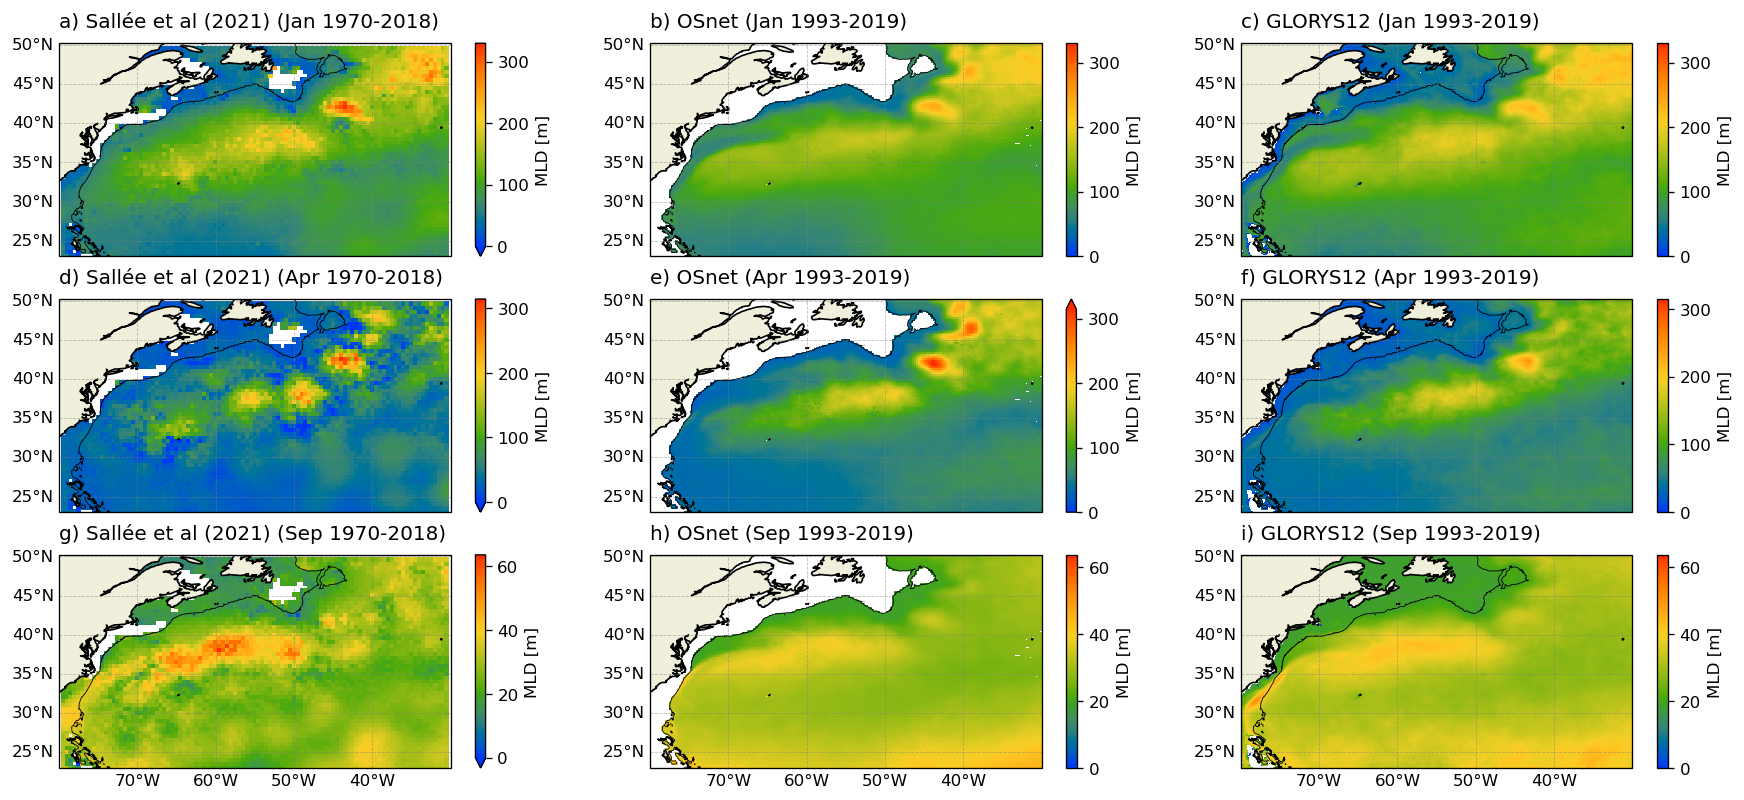

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,8), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
t = 0
cm = cc.cm["rainbow"]
for m in [0,3,8]:
    vm = MLD_sallee.isel(time = m).max().values
    #Sallee:2021aa
    MLD_sallee.isel(time = m).plot(ax=ax[t,0],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]'})
    #OSnet
    ds_mean.isel(month = m).plot(ax = ax[t,1],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]'})
    #GLORYS12
    glorys_mean.MLD.isel(month=m).plot(ax = ax[t,2],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]'})
    t = t+1
    
#Maps and bathymetry
l = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']
k = 0
for i in np.arange(3):
    for j in np.arange(3):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        if i==0:
            gl.bottom_labels = False
        if i==1:
            gl.bottom_labels = False
        if j==0:
            ax[i,j].set_title(l[k] + ' Sallée et al (2021) (' + mm[i] + ' 1970-2018)', loc='left')
        if j==1:
            ax[i,j].set_title(l[k] + ' OSnet (' + mm[i] + ' 1993-2019)', loc='left')
        if j==2:
            ax[i,j].set_title(l[k] + ' GLORYS12 (' + mm[i] + ' 1993-2019)', loc='left')
        k = k+1
    
plt.savefig(pathfig + 'MLD_climato.png', transparent=False)

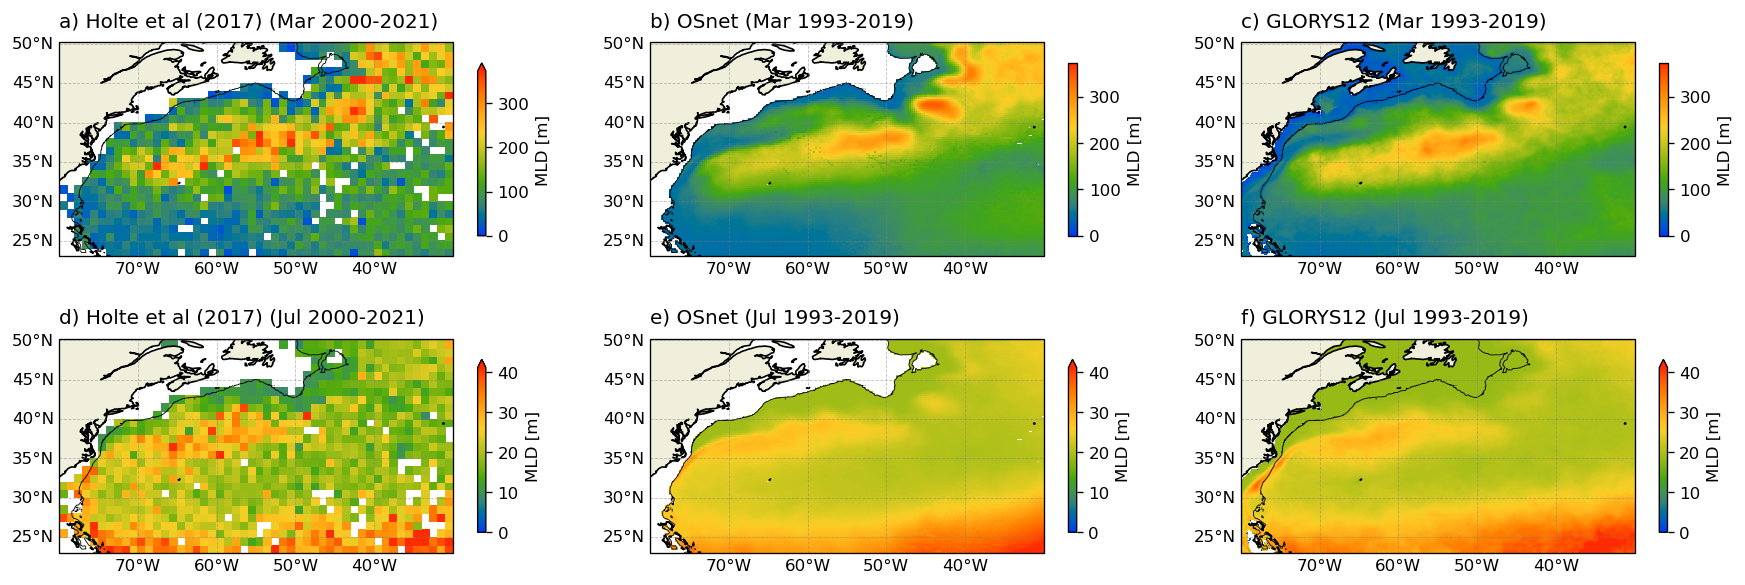

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
t = 0
cm = cc.cm["rainbow"]
for m in [2, 7]:
    vm = MLD_sallee.isel(time = m).max().values
    ds_holte.isel(iMONTH = m).mld_dt_mean.plot(ax=ax[t,0],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]', "shrink": 0.7})
    #OSnet
    ds_mean.isel(month = m).plot(ax = ax[t,1],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]', "shrink": 0.7})
    #GLORYS12
    glorys_mean.MLD.isel(month=m).plot(ax = ax[t,2],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]', "shrink": 0.7})
    t = t+1
    
#Maps and bathymetry
l = ['a)','b)','c)','d)','e)','f)','g)','h)','i)','j)']
k = 0
for i in np.arange(2):
    for j in np.arange(3):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        if j==0:
            ax[i,j].set_title(l[k] + ' Holte et al (2017) (' + mm[i] + ' 2000-2021)', loc='left')
        if j==1:
            ax[i,j].set_title(l[k] + ' OSnet (' + mm[i] + ' 1993-2019)', loc='left')
        if j==2:
            ax[i,j].set_title(l[k] + ' GLORYS12 (' + mm[i] + ' 1993-2019)', loc='left')
        k = k+1

plt.savefig('./MLD_climato_Holte.png', transparent=False)
plt.savefig(pathfig + 'MLD_climato_Holte.png', transparent=False)

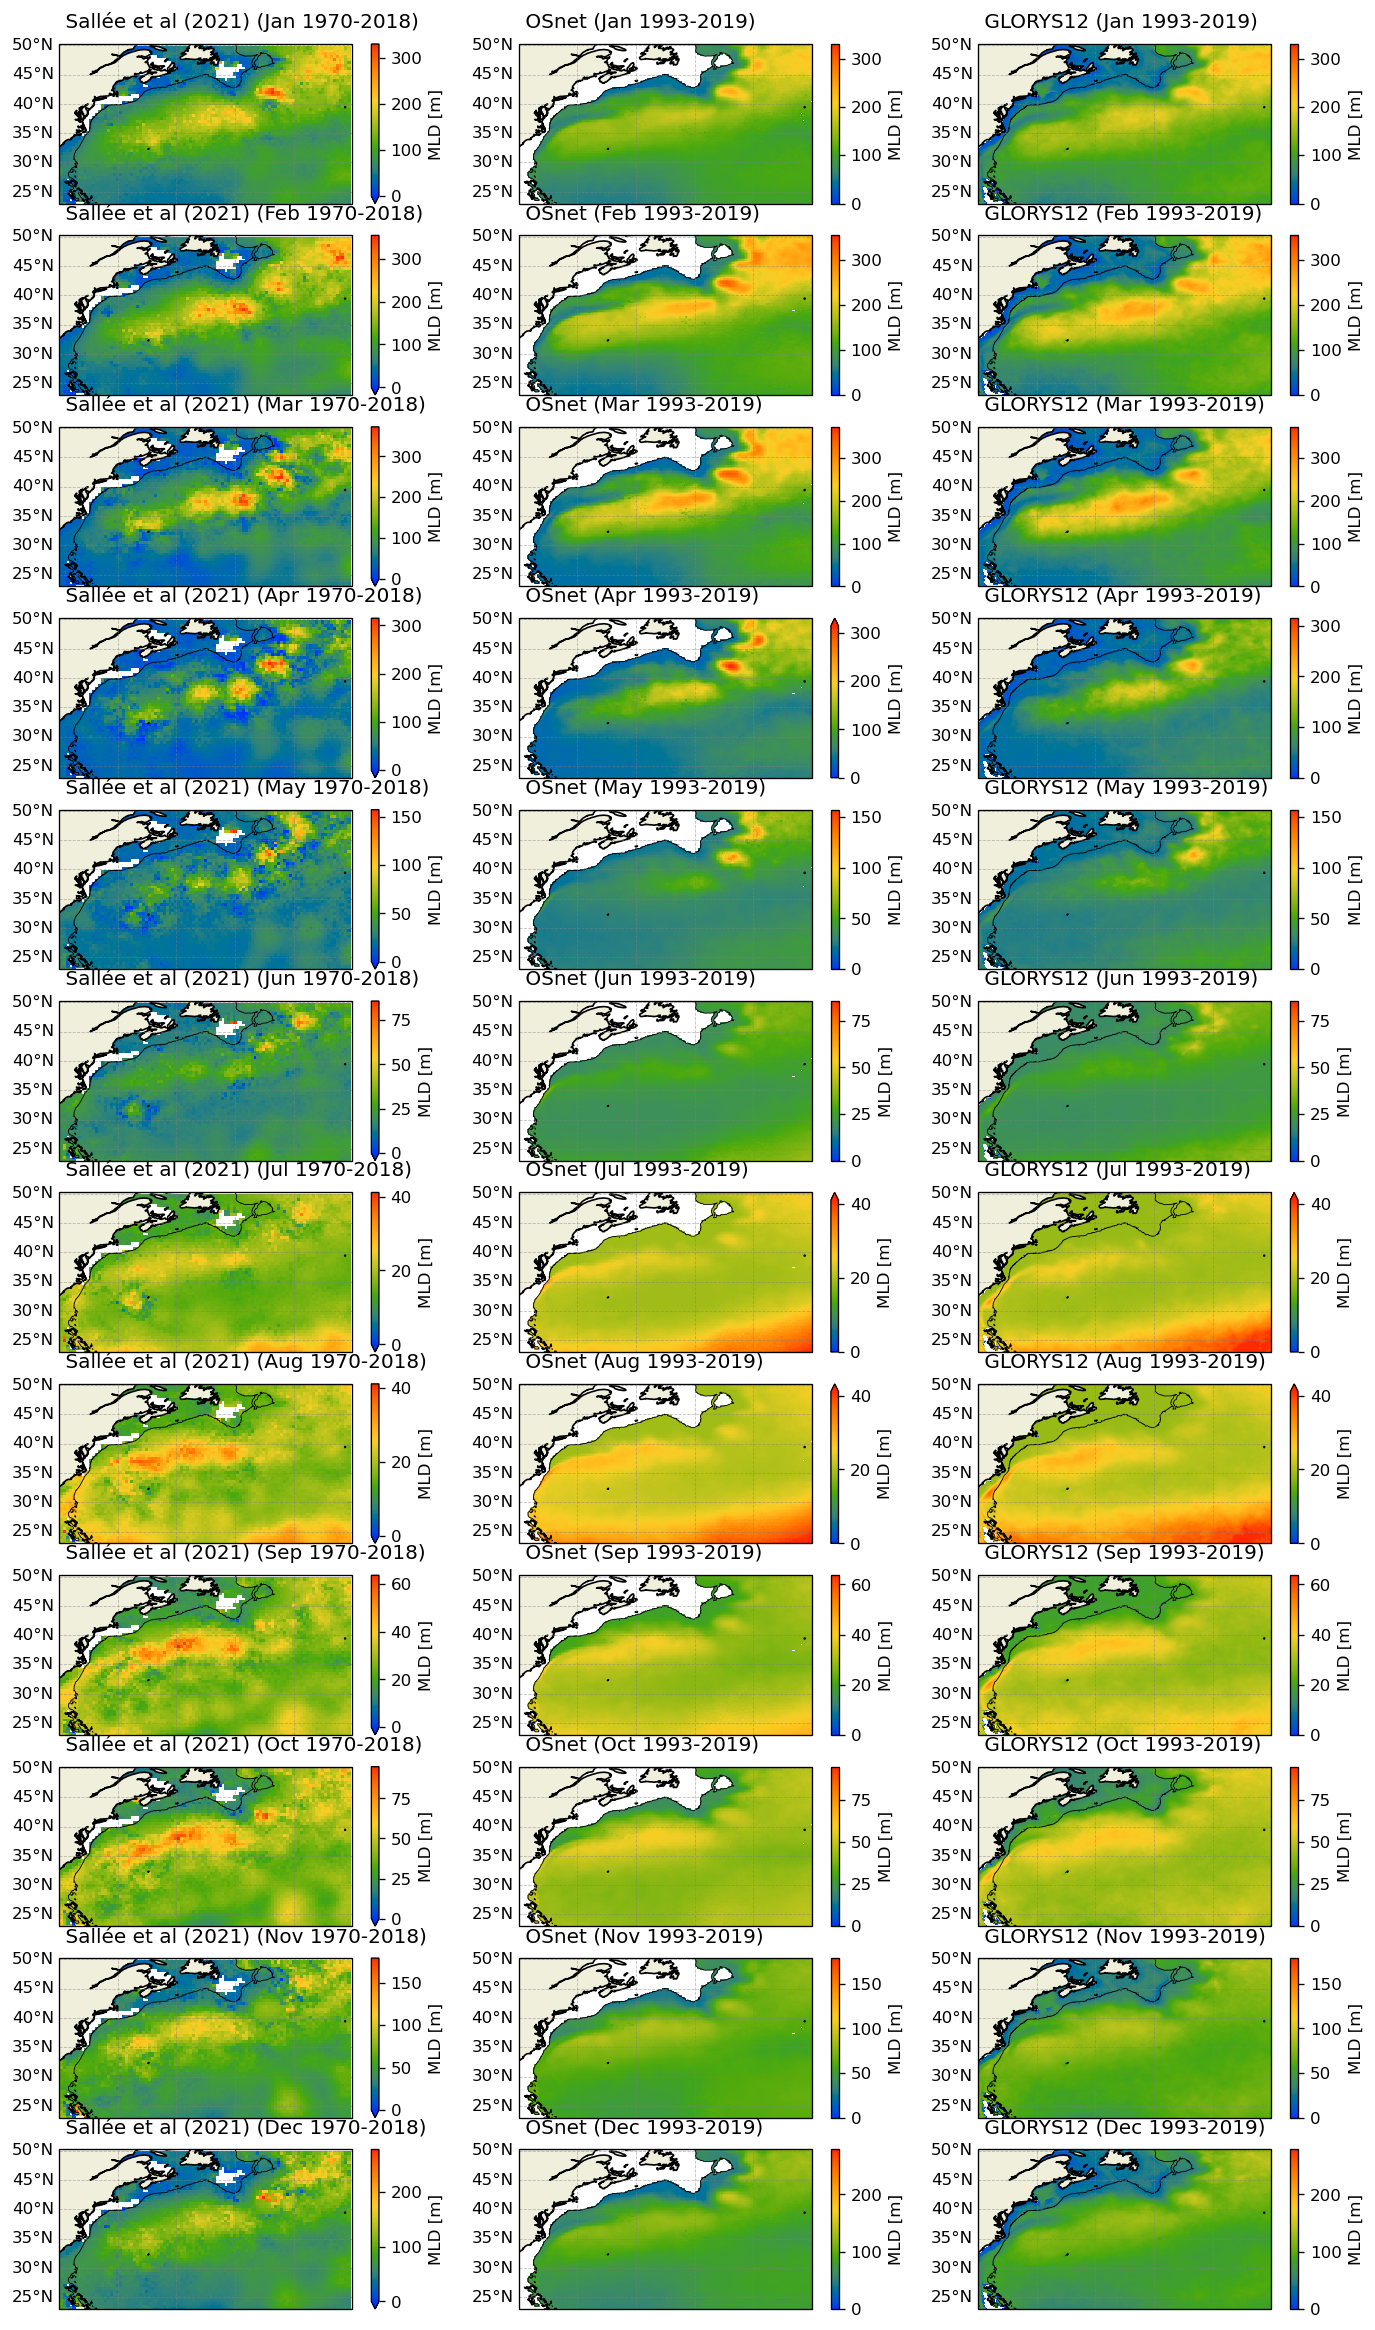

In [13]:
#Plot all the months
t = 0
fig, ax = plt.subplots(nrows=12, ncols=3, figsize=(14,25), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
t = 0
cm = cc.cm["rainbow"]
for m in np.arange(12):
    vm = MLD_sallee.isel(time = m).max().values
    #Sallee:2021aa
    MLD_sallee.isel(time = m).plot(ax=ax[t,0],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]'})
    #OSnet
    ds_mean.isel(month = m).plot(ax = ax[t,1],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]'})
    #GLORYS12
    glorys_mean.MLD.isel(month=m).plot(ax = ax[t,2],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]'})
    t = t+1
    
#Maps and bathymetry
for i in np.arange(12):
    for j in np.arange(3):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        if j==0:
            ax[i,j].set_title(' Sallée et al (2021) (' + months[i] + ' 1970-2018)', loc='left')
        if j==1:
            ax[i,j].set_title(' OSnet (' + months[i] + ' 1993-2019)', loc='left')
        if j==2:
            ax[i,j].set_title(' GLORYS12 (' + months[i] + ' 1993-2019)', loc='left')
    
plt.savefig(pathfig + 'MLD_climato_full.png', transparent=False)


IndexError: list index out of range

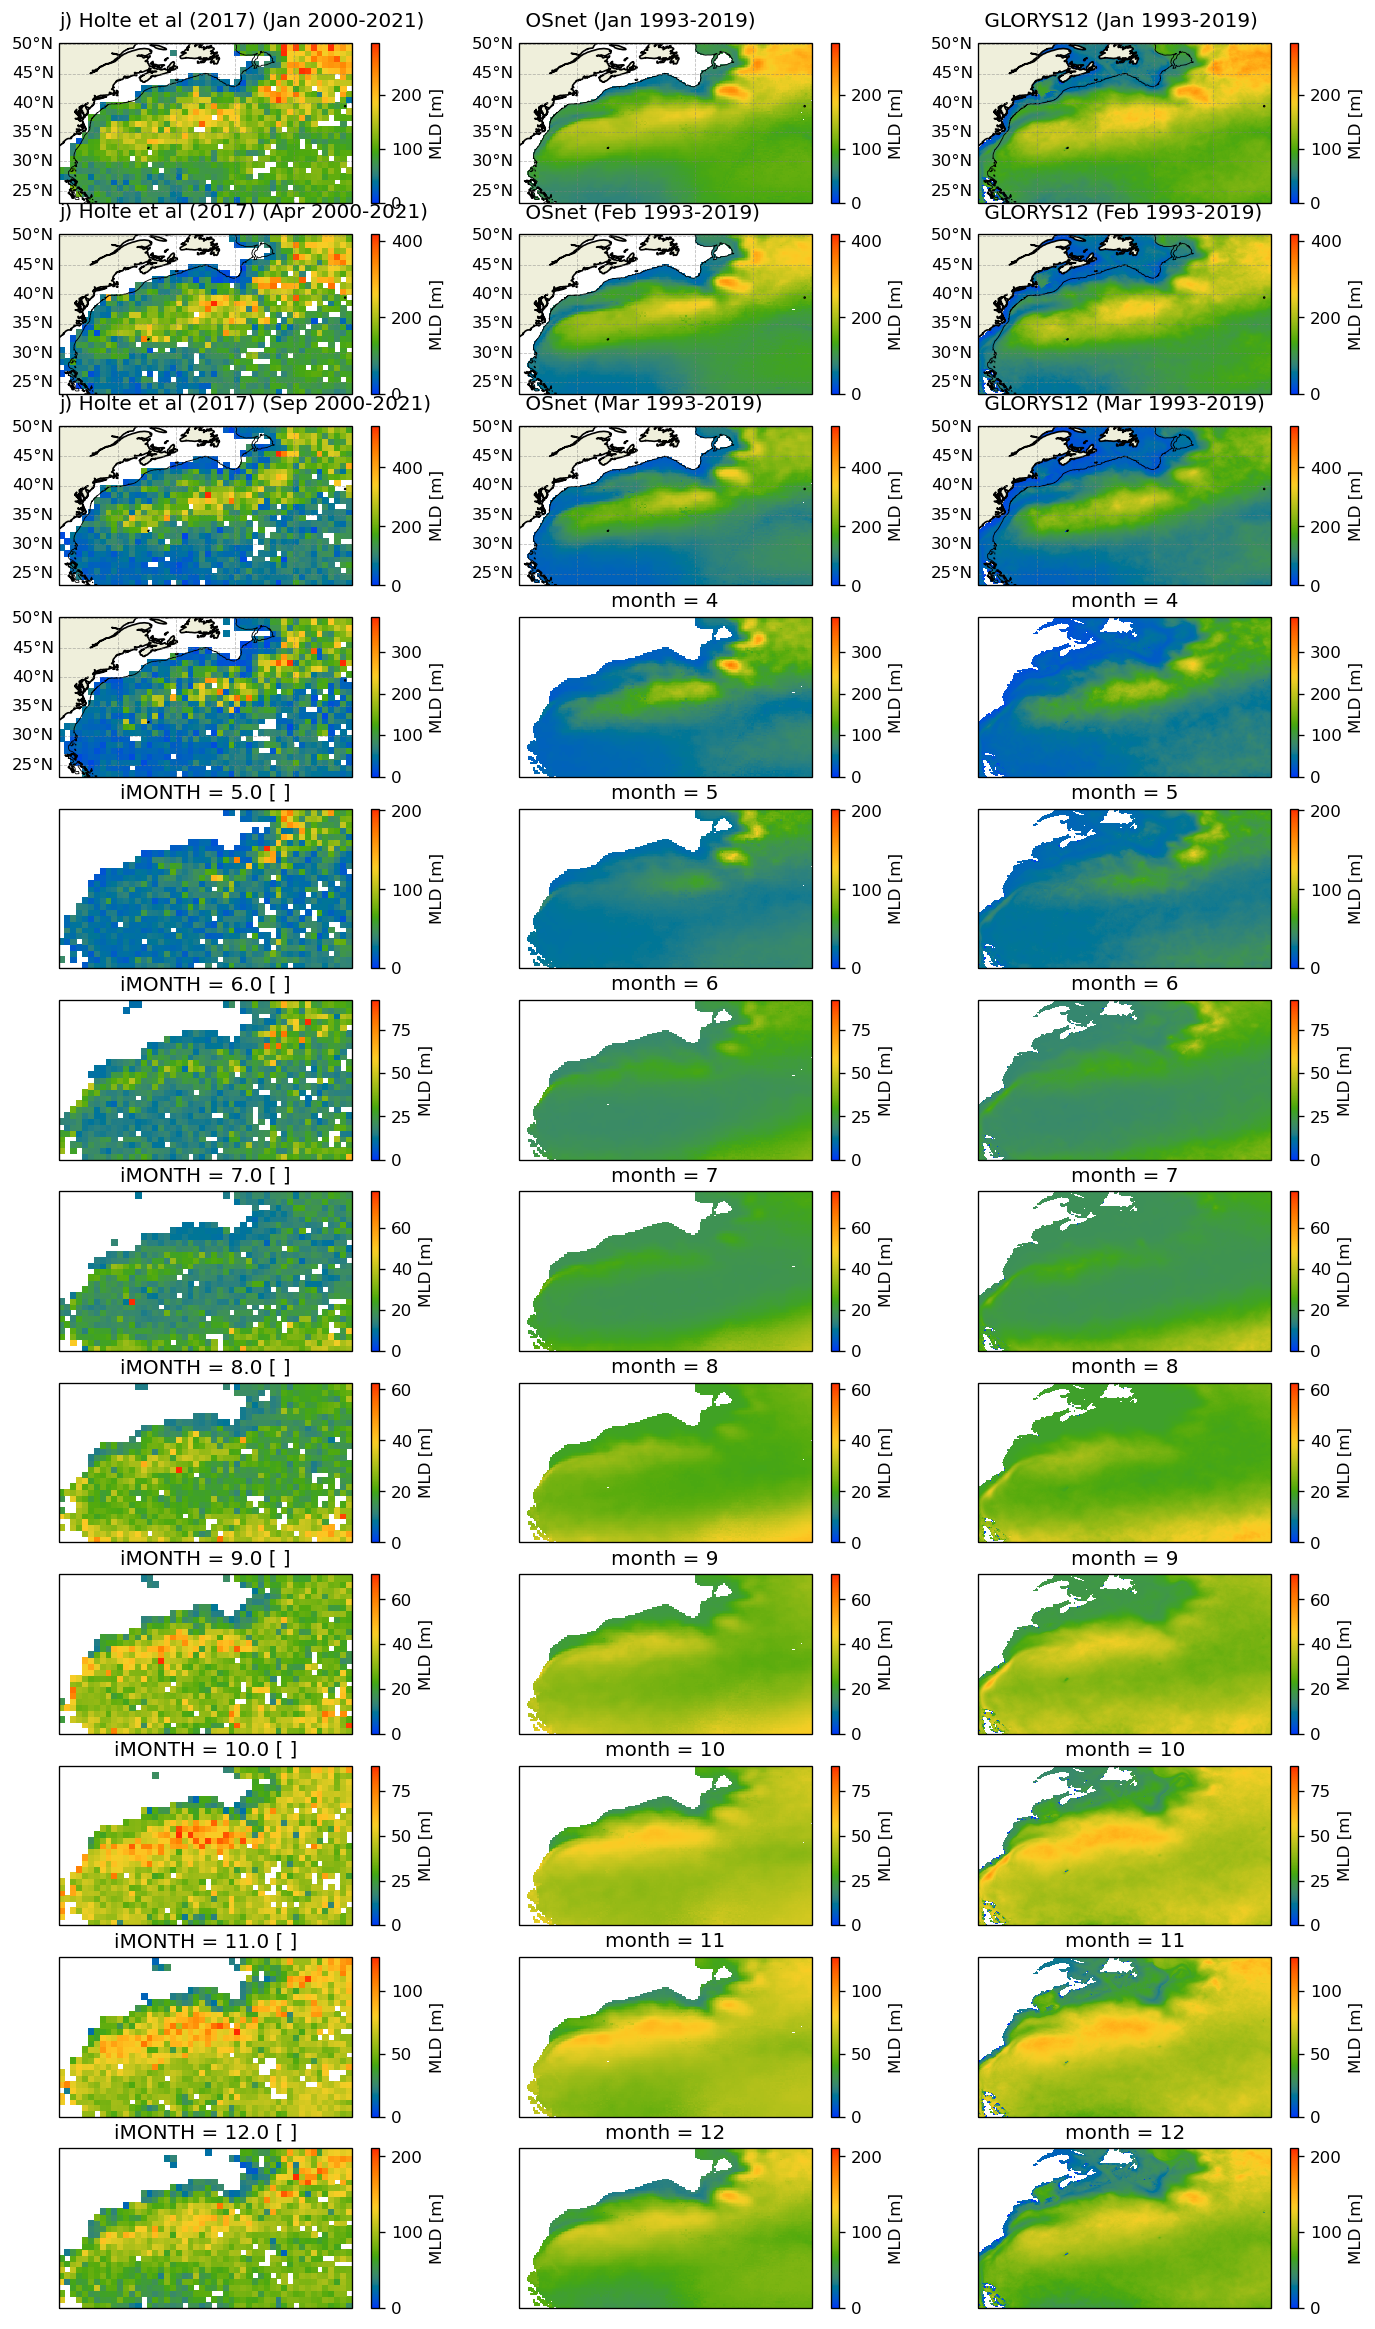

In [17]:
#Plot all the months
t = 0
fig, ax = plt.subplots(nrows=12, ncols=3, figsize=(14,25), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
t = 0
cm = cc.cm["rainbow"]
for m in np.arange(12):
    vm = ds_holte.isel(iMONTH = m).mld_dt_mean.max().values
    #Sallee:2021aa
    ds_holte.isel(iMONTH = m).mld_dt_mean.plot(ax=ax[t,0],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]'})
    #OSnet
    ds_mean.isel(month = m).plot(ax = ax[t,1],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]'})
    #GLORYS12
    glorys_mean.MLD.isel(month=m).plot(ax = ax[t,2],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs={"label":'MLD [m]'})
    t = t+1
    
#Maps and bathymetry
for i in np.arange(12):
    for j in np.arange(3):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[i,j])
        ax[i,j].add_feature(land_feature, edgecolor='black')
        gl = ax[i,j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        if j==0:
            ax[i,j].set_title(l[k] + ' Holte et al (2017) (' + mm[i] + ' 2000-2021)', loc='left')
        if j==1:
            ax[i,j].set_title(' OSnet (' + months[i] + ' 1993-2019)', loc='left')
        if j==2:
            ax[i,j].set_title(' GLORYS12 (' + months[i] + ' 1993-2019)', loc='left')
    
plt.savefig(pathfig + 'MLD_climato_full_Holte.png', transparent=False)

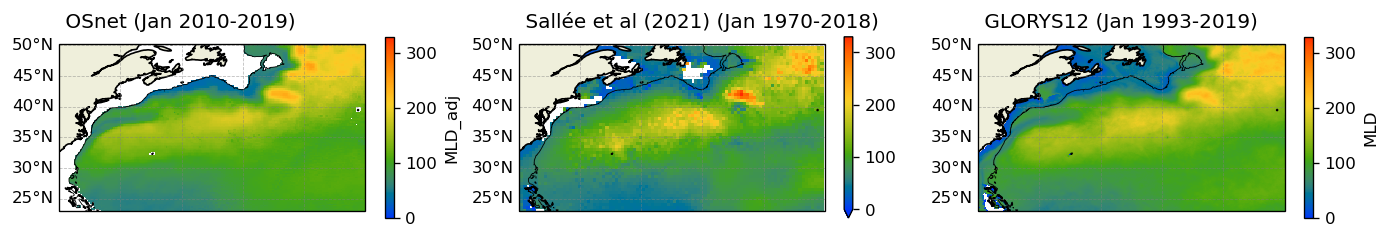

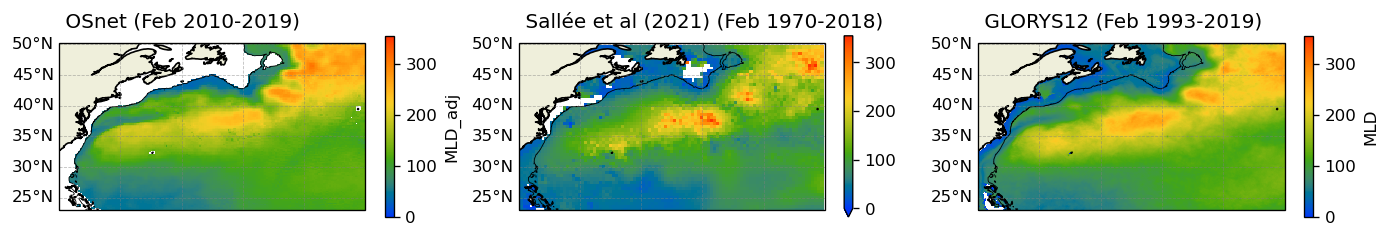

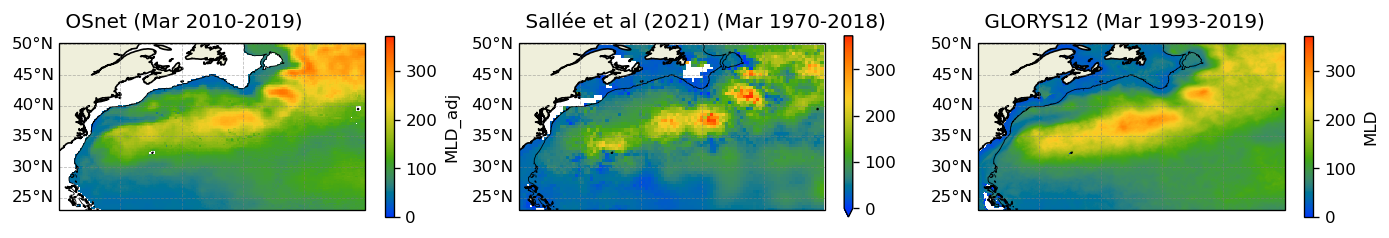

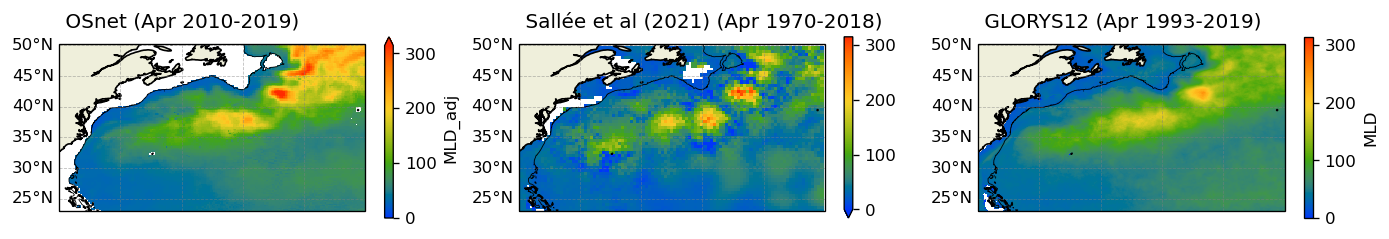

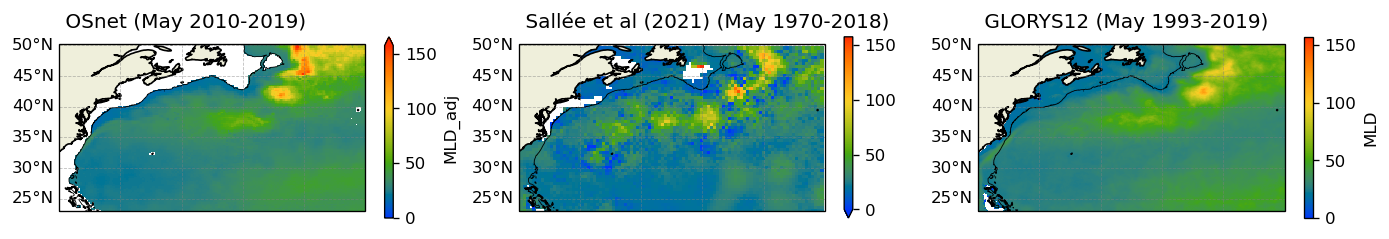

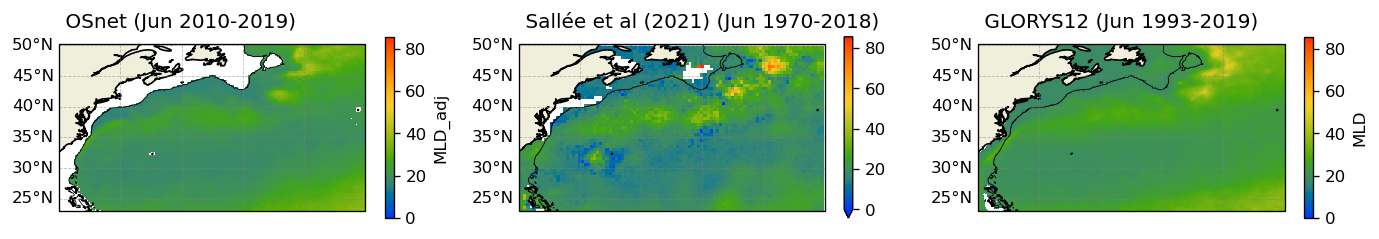

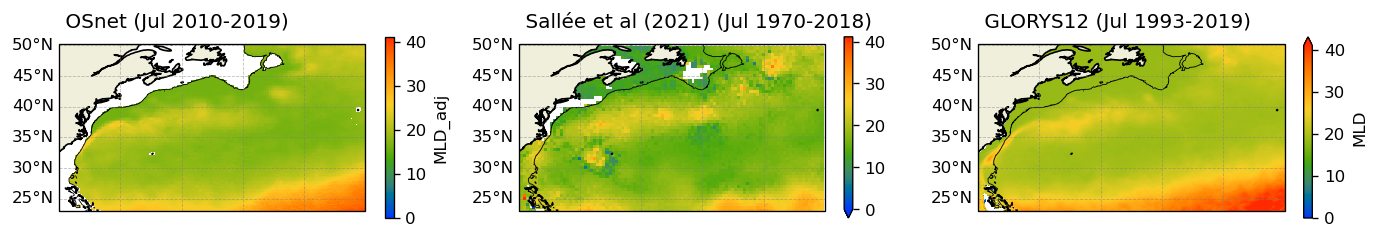

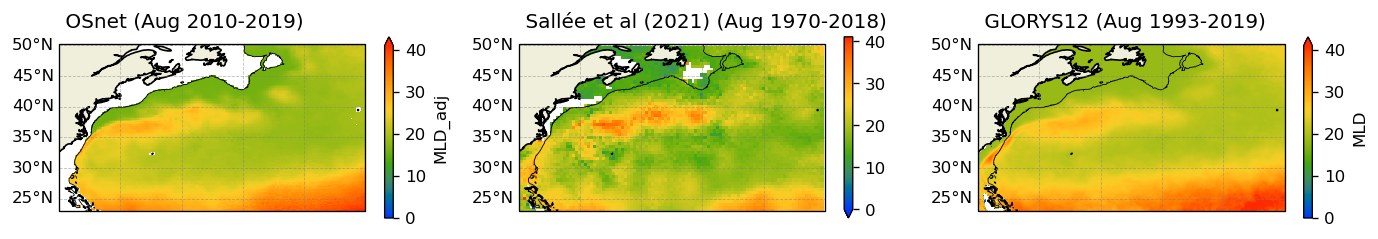

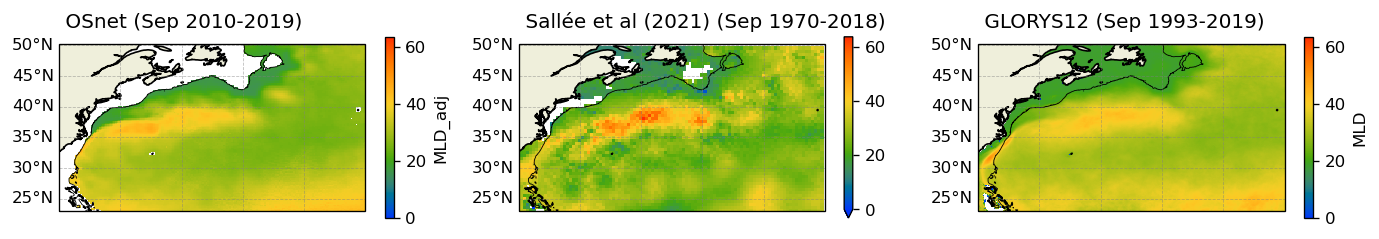

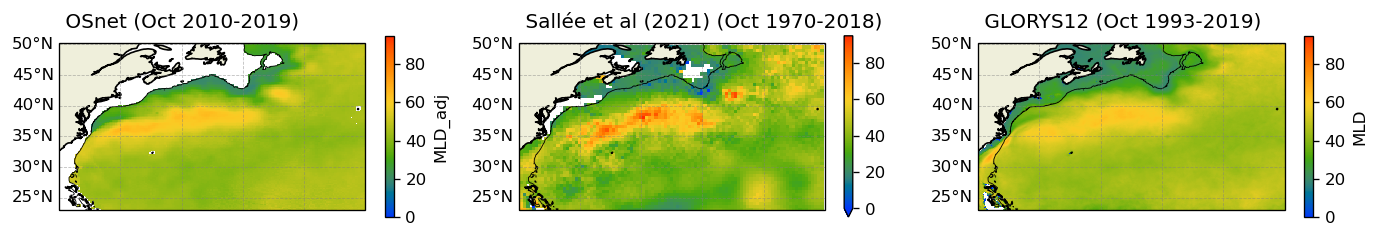

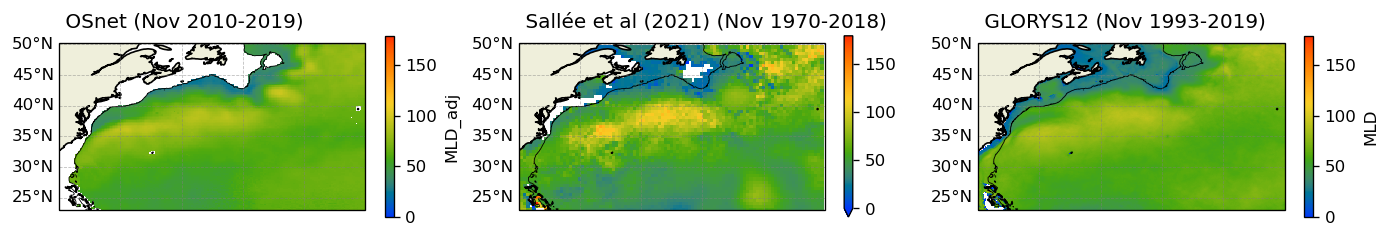

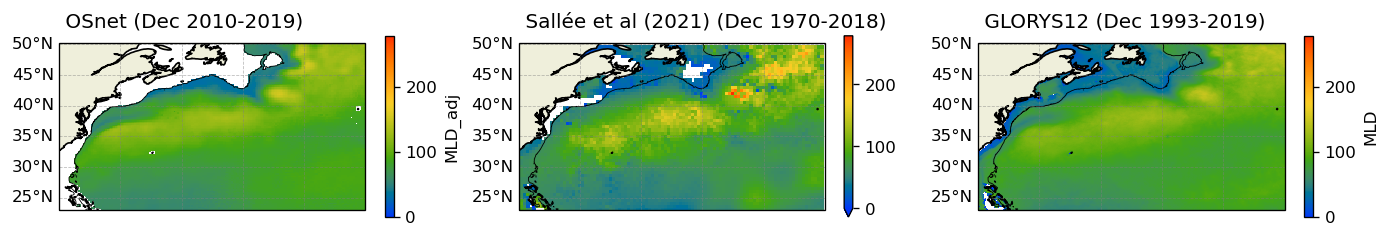

In [30]:
#Plot all the months one by one for the GIF
#vm = 300
for m in np.arange(12):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14,5), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)
    cm = cc.cm["rainbow"]
    vm = MLD_sallee.isel(time = m).max().values
    ds_mean.MLD_adj.isel(month = m).plot(ax = ax[0],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs = dict(shrink=0.4))
    #Sallee:2021aa
    MLD_sallee.isel(time = m).plot(ax=ax[1],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs = dict(shrink=0.4))
    #GLORYS12
    glorys_mean.MLD.isel(month=m).plot(ax = ax[2],vmin = 0,vmax = vm,cmap=cm,cbar_kwargs = dict(shrink=0.4))

    #Maps and bathymetry
    for j in np.arange(3):
        ds_bat['bathymetry'].plot.contour(**kw,ax = ax[j])
        ax[j].add_feature(land_feature, edgecolor='black')
        gl = ax[j].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        gl.bottom_labels = False
        if j==0:
            ax[j].set_title(' OSnet (' + months[m] + ' 2010-2019)', loc='left')
        if j==1:
            ax[j].set_title(' Sallée et al (2021) (' + months[m] + ' 1970-2018)', loc='left')
        if j==2:
            ax[j].set_title(' GLORYS12 (' + months[m] + ' 1993-2019)', loc='left')

    plt.savefig(pathfig + 'MLD_climato_'+ str(m) +'.png', transparent=False)

<Figure size 432x288 with 0 Axes>